## Essential Imports

In [1]:
from glob import glob
import os
import csv
import numpy as np
from torchvision import transforms
import cv2
import torch
import torch.nn as nn
import torch.nn.functional
import torchvision
from torch.utils.data import Dataset, Subset, random_split, DataLoader
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import sys
import shutil

## Loading AMIDA13 from drive

In [2]:
# !unzip /kaggle/input/amida13-augmented 

# Dataset loader

In [3]:
class Amida13Dataset():
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(os.path.join(data_dir, 'images')) if f.endswith('.jpg') or f.endswith('.png')]


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.data_dir, 'images', image_name)
        mask_path = os.path.join(self.data_dir, 'masks', image_name.replace('.jpg', '.png'))
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask


# Define transforms for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Create an instance of the custom dataset
data_dir = r'AMIDA13'
dataset = Amida13Dataset(data_dir, transform=transform)


# Define the sizes of train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into train, validation, and test sets
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])


# Create data loaders for train, validation, and test sets
batch_size = 64

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [4]:
# check the size of the datasets
print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")


Train set size: 76179
Validation set size: 9522
Test set size: 9523


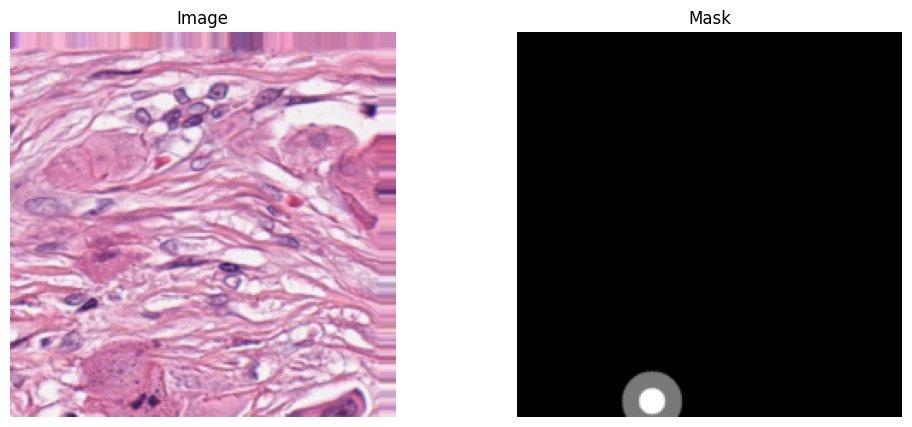

In [5]:
# check if the data is loaded correctly
# display the first image and mask from the train set
image, mask = next(iter(train_loader))
image = image[0].permute(1, 2, 0).numpy()
mask = mask[0].permute(1, 2, 0).numpy()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(mask[:, :, 0], cmap='gray')
plt.axis('off')
plt.title('Mask')
plt.show()

# Swin-Unet Architecture

In [6]:
def window_partition(x, window_size):
    B, H, W, C = x.shape
    x = x.view(B, H // window_size[0], window_size[0], W // window_size[1], window_size[1], C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size[0], window_size[1], C)
    return windows

def window_reverse(windows, window_size, H, W):
    C = windows.shape[-1]
    x = windows.view(-1, H // window_size[0], W // window_size[1], window_size[0], window_size[1], C)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, H, W, C)
    return x

def get_relative_position_index(win_h: int, win_w: int):
    # get pair-wise relative position index for each token inside the window
    coords = torch.stack(torch.meshgrid(torch.arange(win_h), torch.arange(win_w),indexing='ij'))  # 2, Wh, Ww
    coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
    relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
    relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
    relative_coords[:, :, 0] += win_h - 1  # shift to start from 0
    relative_coords[:, :, 1] += win_w - 1
    relative_coords[:, :, 0] *= 2 * win_w - 1
    return relative_coords.sum(-1)  # Wh*Ww, Wh*Ww

class WindowAttention(nn.Module):
    def __init__(
            self,
            dim,
            window_size,
    ):
        super().__init__()
        self.window_size = window_size
        self.window_area = self.window_size[0]*self.window_size[1]
        self.num_heads = 4
        head_dim =  dim // self.num_heads
        # attn_dim = head_dim * self.num_heads
        self.scale = head_dim ** -0.5

        self.relative_position_bias_table = nn.Parameter(torch.zeros((2 * window_size[0] - 1) **2, self.num_heads))

        # get pair-wise relative position index for each token inside the window
        self.register_buffer("relative_position_index", get_relative_position_index(self.window_size[0], self.window_size[1]), persistent=False)

        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)

        torch.nn.init.trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def _get_rel_pos_bias(self):
        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.view(-1)].view(self.window_area, self.window_area, -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        return relative_position_bias.unsqueeze(0)

    def forward(self, x, mask = None):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)


        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        attn = attn + self._get_rel_pos_bias()
        if mask is not None:
            num_win = mask.shape[0]
            attn = attn.view(-1, num_win, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
        attn = self.softmax(attn)
        x = attn @ v

        x = x.transpose(1, 2).reshape(B_, N, -1)
        x = self.proj(x)
        return x

In [7]:
class SwinTransformerBlock(nn.Module):
    def __init__(
            self,  dim, input_resolution, window_size = 7, shift_size = 0):

        super().__init__()
        self.input_resolution = input_resolution
        window_size = (window_size, window_size)
        shift_size = (shift_size, shift_size)
        self.window_size = window_size
        self.shift_size = shift_size
        self.window_area = self.window_size[0] * self.window_size[1]

        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(
            dim,
            window_size=self.window_size,
        )

        self.norm2 = nn.LayerNorm(dim)

        self.mlp = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.GELU(),
            nn.LayerNorm(4 * dim),
            nn.Linear( 4 * dim, dim)
        )

        if self.shift_size:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            H = math.ceil(H / self.window_size[0]) * self.window_size[0]
            W = math.ceil(W / self.window_size[1]) * self.window_size[1]
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            cnt = 0
            for h in (
                    slice(0, -self.window_size[0]),
                    slice(-self.window_size[0], -self.shift_size[0]),
                    slice(-self.shift_size[0], None)):
                for w in (
                        slice(0, -self.window_size[1]),
                        slice(-self.window_size[1], -self.shift_size[1]),
                        slice(-self.shift_size[1], None)):
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_area)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask, persistent=False)

    def _attn(self, x):
        B, H, W, C = x.shape

        # cyclic shift
        if self.shift_size:
            shifted_x = torch.roll(x, shifts=(-self.shift_size[0], -self.shift_size[1]), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_area, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size[0], self.window_size[1], C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C
        shifted_x = shifted_x[:, :H, :W, :].contiguous()

        # reverse cyclic shift
        if self.shift_size:
            x = torch.roll(shifted_x, shifts=self.shift_size, dims=(1, 2))
        else:
            x = shifted_x
        return x

    def forward(self, x):
        B, H, W, C = x.shape
        B, H, W, C = x.shape
        x = x + self._attn(self.norm1(x))
        x = x.reshape(B, -1, C)
        x = x + self.mlp(self.norm2(x))
        x = x.reshape(B, H,W, C)
        return x


In [8]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_ch, num_feat, patch_size):
        super().__init__()
        self.conv = nn.Conv2d(in_ch,num_feat, kernel_size=patch_size,
                                  stride=patch_size)

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        return self.conv(X).permute(0,2,3,1)

class PatchMerging(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(4 * dim)
        self.reduction = nn.Linear(4*dim, 2*dim, bias=False)

    def forward(self, x):
        B, H, W, C = x.shape
        x = x.reshape(B, H // 2, 2, W // 2, 2, C).permute(0, 1, 3, 4, 2, 5).flatten(3)
        x = self.norm(x)
        x = self.reduction(x)
        return x

class PatchExpansion(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(dim//2)
        self.expand = nn.Linear(dim, 2*dim, bias=False)

    def forward(self, x):

        x = self.expand(x)
        B, H, W, C = x.shape

        x = x.view(B, H , W, 2, 2, C//4)
        x = x.permute(0,1,3,2,4,5)

        x = x.reshape(B,H*2, W*2 , C//4)

        x = self.norm(x)
        return x

class FinalPatchExpansion(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.expand = nn.Linear(dim, 16*dim, bias=False)

    def forward(self, x):

        x = self.expand(x)
        B, H, W, C = x.shape

        x = x.view(B, H , W, 4, 4, C//16)
        x = x.permute(0,1,3,2,4,5)

        x = x.reshape(B,H*4, W*4 , C//16)

        x = self.norm(x)
        return x

In [9]:
class SwinBlock(nn.Module):
    def __init__(self, dims, ip_res, ss_size = 3):
        super().__init__()
        self.swtb1 = SwinTransformerBlock(dim=dims, input_resolution=ip_res)
        self.swtb2 = SwinTransformerBlock(dim=dims, input_resolution=ip_res, shift_size=ss_size)

    def forward(self, x):
        return self.swtb2(self.swtb1(x))


class Encoder(nn.Module):
    def __init__(self, C, partioned_ip_res, num_blocks=3):
        super().__init__()
        H,W = partioned_ip_res[0], partioned_ip_res[1]
        self.enc_swin_blocks = nn.ModuleList([
            SwinBlock(C, (H, W)),
            SwinBlock(2*C, (H//2, W//2)),
            SwinBlock(4*C, (H//4, W//4))
        ])
        self.enc_patch_merge_blocks = nn.ModuleList([
            PatchMerging(C),
            PatchMerging(2*C),
            PatchMerging(4*C)
        ])

    def forward(self, x):
        skip_conn_ftrs = []
        for swin_block,patch_merger in zip(self.enc_swin_blocks, self.enc_patch_merge_blocks):
            x = swin_block(x)
            skip_conn_ftrs.append(x)
            x = patch_merger(x)
        return x, skip_conn_ftrs


class Decoder(nn.Module):
    def __init__(self, C, partioned_ip_res, num_blocks=3):
        super().__init__()
        H,W = partioned_ip_res[0], partioned_ip_res[1]
        self.dec_swin_blocks = nn.ModuleList([
            SwinBlock(4*C, (H//4, W//4)),
            SwinBlock(2*C, (H//2, W//2)),
            SwinBlock(C, (H, W))
        ])
        self.dec_patch_expand_blocks = nn.ModuleList([
            PatchExpansion(8*C),
            PatchExpansion(4*C),
            PatchExpansion(2*C)
        ])
        self.skip_conn_concat = nn.ModuleList([
            nn.Linear(8*C, 4*C),
            nn.Linear(4*C, 2*C),
            nn.Linear(2*C, 1*C)
        ])

    def forward(self, x, encoder_features):
        for patch_expand,swin_block, enc_ftr, linear_concatter in zip(self.dec_patch_expand_blocks, self.dec_swin_blocks, encoder_features,self.skip_conn_concat):
            x = patch_expand(x)
            x = torch.cat([x, enc_ftr], dim=-1)
            x = linear_concatter(x)
            x = swin_block(x)
        return x
    
class SwinUNet(nn.Module):
    def __init__(self, H, W, ch, C, num_class, num_blocks=3, patch_size = 4):
        super().__init__()
        self.patch_embed = PatchEmbedding(ch, C, patch_size)
        self.encoder = Encoder(C, (H//patch_size, W//patch_size),num_blocks)
        self.bottleneck = SwinBlock(C*(2**num_blocks), (H//(patch_size* (2**num_blocks)), W//(patch_size* (2**num_blocks))))
        self.decoder = Decoder(C, (H//patch_size, W//patch_size),num_blocks)
        self.final_expansion = FinalPatchExpansion(C)
        self.head        = nn.Conv2d(C, num_class, 1,padding='same')

    def forward(self, x):
        x = self.patch_embed(x)

        x,skip_ftrs  = self.encoder(x)

        x = self.bottleneck(x)

        x = self.decoder(x, skip_ftrs[::-1])

        x = self.final_expansion(x)

        x = self.head(x.permute(0,3,1,2))

        return x


# Custom loss function

In [9]:
def DiceLoss(self, inputs, targets, smooth=1):
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
    

def DiceBCELoss(self, inputs, targets, smooth=1):

        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

# Model training

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNet(224,224,1,32,1,3,4).to(device)

for p in model.parameters():
    if p.dim() > 1:
            nn.init.kaiming_uniform_(p)

optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCEWithLogitsLoss()

max_epochs=3


# Loop over epochs
for epoch in range(max_epochs):
    # Training
    print(f"Epoch {epoch+1}/{max_epochs}:")
    train_loss = 0.0
    for i, (local_batch, local_labels) in enumerate(train_loader, 1):
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)

        # Model computations
        optimizer.zero_grad()
        out = model(local_batch)
        loss = loss_fn(out, local_labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Print training progress
        if i % 100 == 0:  # Print every 100 batches
            print(f"  Batch {i}/{len(train_loader)}, Loss: {loss.item():.4f}")

    # Calculate average training loss
    train_loss /= len(train_loader)

    # Validation
    with torch.set_grad_enabled(False):
        val_loss = 0.0
        for i, (local_batch, local_labels) in enumerate(val_loader, 1):
            # Transfer to GPU
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)

            # Model computations
            out = model(local_batch)
            loss = loss_fn(out, local_labels)
            val_loss += loss.item()

    # Calculate average validation loss
    val_loss /= len(val_loader)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{max_epochs}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


Epoch 1/3:
  Batch 100/1191, Loss: 0.0339
  Batch 200/1191, Loss: 0.0362
  Batch 300/1191, Loss: 0.0275
  Batch 400/1191, Loss: 0.0184
  Batch 500/1191, Loss: 0.0179
  Batch 600/1191, Loss: 0.0212
  Batch 700/1191, Loss: 0.0194
  Batch 800/1191, Loss: 0.0162
  Batch 900/1191, Loss: 0.0181
  Batch 1000/1191, Loss: 0.0163
  Batch 1100/1191, Loss: 0.0181
Epoch 1/3: Train Loss: 0.0253, Validation Loss: 0.0172
Epoch 2/3:
  Batch 100/1191, Loss: 0.0186
  Batch 200/1191, Loss: 0.0165
  Batch 300/1191, Loss: 0.0149
  Batch 400/1191, Loss: 0.0142
  Batch 500/1191, Loss: 0.0221
  Batch 600/1191, Loss: 0.0148
  Batch 700/1191, Loss: 0.0197
  Batch 800/1191, Loss: 0.0146
  Batch 900/1191, Loss: 0.0152
  Batch 1000/1191, Loss: 0.0170
  Batch 1100/1191, Loss: 0.0141
Epoch 2/3: Train Loss: 0.0162, Validation Loss: 0.0156
Epoch 3/3:
  Batch 100/1191, Loss: 0.0211
  Batch 200/1191, Loss: 0.0171
  Batch 300/1191, Loss: 0.0138
  Batch 400/1191, Loss: 0.0124
  Batch 500/1191, Loss: 0.0155
  Batch 600/1191

In [13]:
!mkdir /kaggle/working/model
torch.save(model.state_dict(), "/kaggle/working/model/model v4.pth")

# Visualizing results

In [13]:
# load the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNet(224,224,3,32,1,3,4).to(device)
model.load_state_dict(torch.load("model/model_v4_RGB.pth", map_location=device))

model.eval()

SwinUNet(
  (patch_embed): PatchEmbedding(
    (conv): Conv2d(3, 32, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Encoder(
    (enc_swin_blocks): ModuleList(
      (0): SwinBlock(
        (swtb1): SwinTransformerBlock(
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=32, out_features=96, bias=True)
            (proj): Linear(in_features=32, out_features=32, bias=True)
            (softmax): Softmax(dim=-1)
          )
          (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (0): Linear(in_features=32, out_features=128, bias=True)
            (1): GELU(approximate='none')
            (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (3): Linear(in_features=128, out_features=32, bias=True)
          )
        )
        (swtb2): SwinTransformerBlock(
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_aff

TypeError: Invalid shape (3, 224, 224) for image data

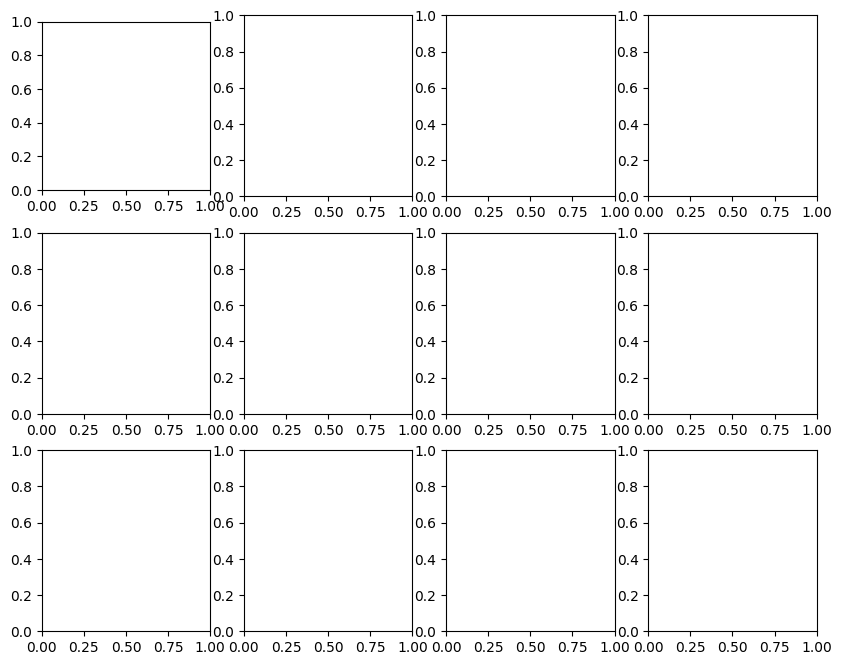

In [12]:
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
fig, ax = plt.subplots(3, 4, figsize=(10, 8))
with torch.no_grad():
  for i in range(3):  # Adjust the range to visualize more rows
    # Get a new batch of images and masks
    x_og, y_og = next(iter(test_loader))
    x = x_og[0]
    y = y_og[0]

    # Visualize image, mask, prediction, and thresholded prediction
    ax[i, 0].imshow(x.squeeze(0).squeeze(0), cmap='gray')
    ax[i, 0].set_title('Image')
    ax[i, 1].imshow(y.squeeze(0).squeeze(0), cmap='gray')
    ax[i, 1].set_title('Mask')

    x_og = x_og.to(device)
    out = model(x_og[:1])
    out = nn.Sigmoid()(out)
    out = out.squeeze(0).squeeze(0).cpu()

    # save the images
    cv2.imwrite(f"image_{i}.png", x.squeeze(0).squeeze(0).numpy()*255)
    cv2.imwrite(f"mask_{i}.png", y.squeeze(0).squeeze(0).numpy()*255)
    cv2.imwrite(f"prediction_{i}.png", (out.numpy()*255).astype(np.uint8))
    cv2.imwrite(f"threshold_prediction_{i}.png", (out.numpy() > 0.3).astype(np.uint8)*255)

    ax[i, 2].imshow(out, cmap='gray')
    ax[i, 2].set_title('Prediction')

    ax[i, 3].imshow((out > 0.3).float(), cmap='gray')
    ax[i, 3].set_title('Threshold Prediction')


plt.show()